# Sleep Questionnaire Analysis

#### This is real data file condensed from a study conducted to explore the prevalence and impact of sleep problems on various aspects of people's lives. Staff from a university in Melbourne, Australia were invited to complete a questionnaire containing questions about their sleep behaviour (e.g. hours slept per night), sleep problems (e.g. difficulty getting to sleep) and the impact that these problems have on aspects of their lives (work, driving, relationships). The sample consisted of 271 respondents (55% female, 45% male) ranging in age from 18 to 84 years (mean=44yrs).

#### Import relevant libraries

In [1]:
# Load in the relevant Python modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Using plotly + cufflinks in offline mode
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import cufflinks
cufflinks.go_offline(connected=True)

import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

#### Import SPSS file

In [2]:
import savReaderWriter as spss
raw_data = spss.SavReader('sleep.sav', ioUtf8=True, returnHeader = True)
raw_data_list = list(raw_data)
header = raw_data_list[0]
data = raw_data_list[1:]
df = pd.DataFrame(data, columns=header)
df.head()

,id,sex,age,marital,edlevel,weight,height,healthrate,fitrate,weightrate,...,sleepy,energy,stayslprec,getsleprec,qualsleeprec,totsas,cigsgp3,agegp3,probsleeprec,drvslprec
0,83.0,0.0,42.0,2.0,2.0,52.0,162.0,10.0,7.0,5.0,...,2.0,2.0,NaN,NaN,4.0,10.0,2.0,2.0,0.0,0.0
1,294.0,0.0,54.0,2.0,5.0,65.0,174.0,8.0,7.0,5.0,...,5.0,5.0,1.0,1.0,3.0,20.0,NaN,3.0,0.0,0.0
2,425.0,1.0,NaN,2.0,2.0,89.0,170.0,6.0,5.0,7.0,...,6.0,5.0,1.0,1.0,1.0,31.0,NaN,NaN,0.0,1.0
3,64.0,0.0,41.0,2.0,5.0,66.0,178.0,9.0,7.0,5.0,...,6.0,8.0,0.0,1.0,3.0,34.0,1.0,2.0,0.0,0.0
4,536.0,0.0,39.0,2.0,5.0,62.0,160.0,9.0,5.0,7.0,...,6.0,6.0,1.0,1.0,3.0,25.0,NaN,2.0,0.0,0.0


In [3]:
# Taking a look at how many rows and columns the train dataset contains
rows = df.shape[0]
columns = df.shape[1]
print("The dataset contains {0} rows and {1} columns".format(rows, columns))

The dataset contains 271 rows and 55 columns


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 55 columns):
id              271 non-null float64
sex             271 non-null float64
age             248 non-null float64
marital         271 non-null float64
edlevel         269 non-null float64
weight          249 non-null float64
height          246 non-null float64
healthrate      267 non-null float64
fitrate         266 non-null float64
weightrate      266 non-null float64
smoke           270 non-null float64
smokenum        35 non-null float64
alchohol        257 non-null float64
caffeine        262 non-null float64
hourwnit        270 non-null float64
hourwend        269 non-null float64
hourneed        266 non-null float64
trubslep        269 non-null float64
trubstay        266 non-null float64
wakenite        271 non-null float64
niteshft        269 non-null float64
liteslp         266 non-null float64
refreshd        264 non-null float64
satsleep        268 non-null float64
qualslp 

#### Check missing values

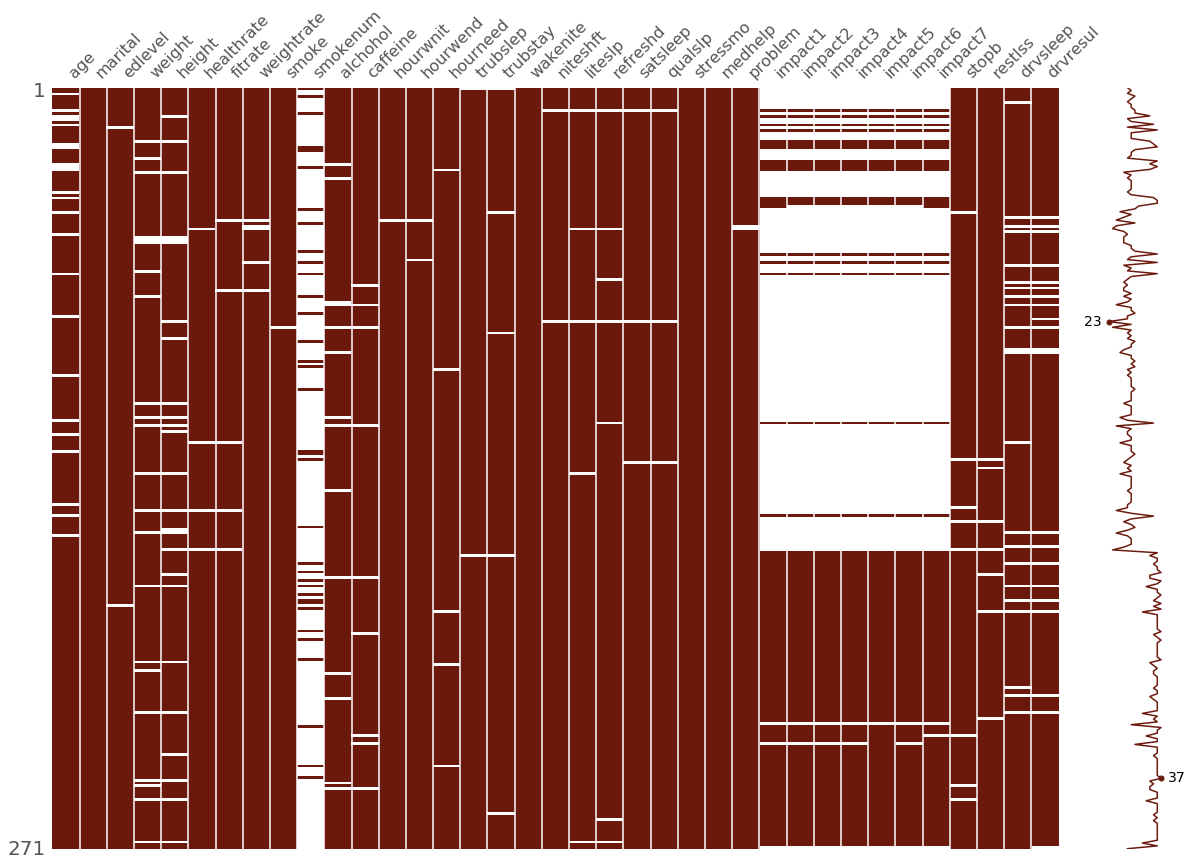

In [5]:
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=df.iloc[:,2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

#### Remove columns with over 50% missing values

In [6]:
NA_columns = df.columns[df.isnull().any()]
NA_data_counts = df.isnull().sum()[df.isnull().any()]
missing_entries_df = pd.DataFrame(data = NA_data_counts, columns = ['# of missing entries'])

drop_names = missing_entries_df[missing_entries_df>(df.shape[0]/2)].dropna()
too_many_so_drop = list(drop_names.T.columns)
df = df[[col for col in df.columns if col not in too_many_so_drop]]

#### Drop lines with missing values

In [7]:
df = df.dropna()
Counter(df.dtypes.values)

Counter({dtype('float64'): 46})

#### Check Age distribution

In [8]:
df.age.value_counts().to_frame().iplot(kind='bar', title="Age variable distribution")

#### Age exploration by gender

In [9]:
trace1 = go.Box(
    name="Female",
    x=df[df['sex'] == 0].age.values,
    marker=dict(
        color='#3D9970'
    )
)
trace2 = go.Box(
    name="Male",
    x=df[df['sex'] == 1].age.values,
    marker=dict(
        color='#FF4136'
    )
)

data = [trace1, trace2]

layout = go.Layout(
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

#### Explore features correlation 

In [10]:
corr = df.corr()
data = [
    go.Heatmap(
        z=corr.values,
        x=list(corr.columns),
        y=list(corr.index),
        colorscale='Viridis',
    )
]

layout = go.Layout(
    title='Features Correlation Matrix',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='corr-heatmap')

#### How many patients have trouble falling asleep?

In [11]:
colors = ['#eba796', '#96ebda']

fig = {'data' : [{'type' : 'pie',
                  'name' : "Patients with Trouble Sleep: Pie chart",
                 'labels' : df['trubslep'].value_counts().index.map(lambda x : 'Yes' if x == 1 else 'No'),
                 'values' : df['trubslep'].value_counts().values,
                 'direction' : 'clockwise',
                 'marker' : {'colors' : ['#9cc359', '#e96b5c']}}], 'layout' : {'title' : 'Patients with Trouble Falling Asleep'}}

py.iplot(fig)

#### Trouble falling asleep by gender

In [12]:
# Select all cases where a patient is having trouble falling sleeping
trace3 = go.Bar(
    x=df[df['trubslep'] == 1]['sex'].value_counts().index.map(lambda x : 'M' if x == 1 else 'F'),
    y=df[df['trubslep'] == 1]['sex'].value_counts().values,
    name='Trouble Sleep'
   
)
# Select all cases where a patient is having no trouble falling sleeping
trace4 = go.Bar(
    x=df[df['trubslep'] == 2]['sex'].value_counts().index.map(lambda x : 'M' if x == 1 else 'F'),
    y=df[df['trubslep'] == 2]['sex'].value_counts().values,
    name='No-Trouble Sleep'
)

data = [trace3, trace4]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

#### Find features that cause troubles falling asleep

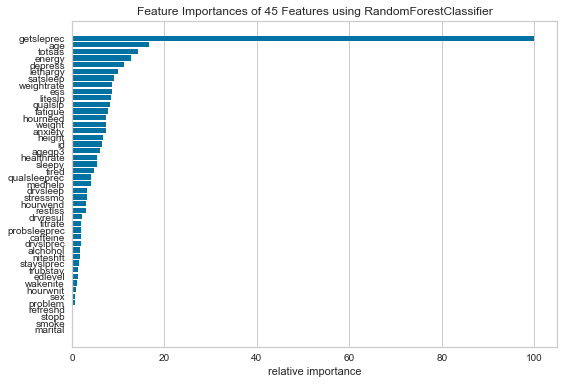

In [13]:
from yellowbrick.features.importances import FeatureImportances
from sklearn.ensemble import RandomForestClassifier

X = df[[col for col in df.columns if col not in ['trubslep']]]
y = df.trubslep

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

viz = FeatureImportances(RandomForestClassifier(), ax=ax)

viz.fit(X, y)
viz.poof()

#### Remove 'Problem getting to sleep recoded' feature and re-check features importance

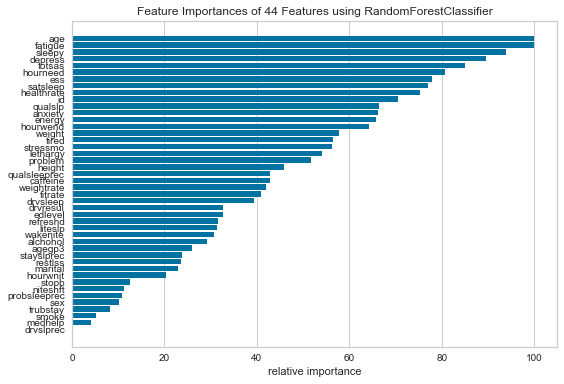

In [14]:
X = df[[col for col in df.columns if col not in ['trubslep', 'getsleprec']]]
y = df.trubslep

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

viz = FeatureImportances(RandomForestClassifier(), ax=ax)

viz.fit(X, y)
viz.poof()

#### Only keep features with relative importance >50

In [15]:
features_to_keep = [fet for (fet, imp) in zip(viz.features_, viz.feature_importances_) if imp > 50]
X = df[[col for col in df.columns if col in features_to_keep]]
y = df.trubslep
features_to_keep

['problem',
 'lethargy',
 'stressmo',
 'tired',
 'weight',
 'hourwend',
 'energy',
 'anxiety',
 'qualslp',
 'id',
 'healthrate',
 'satsleep',
 'ess',
 'hourneed',
 'totsas',
 'depress',
 'sleepy',
 'fatigue',
 'age']

#### How anxious are the patients?

In [16]:
df.anxiety.value_counts().to_frame().iplot(kind='bar', title="Anxiety variable distribution")

#### Train a model to detect patients who have trouble falling asleep

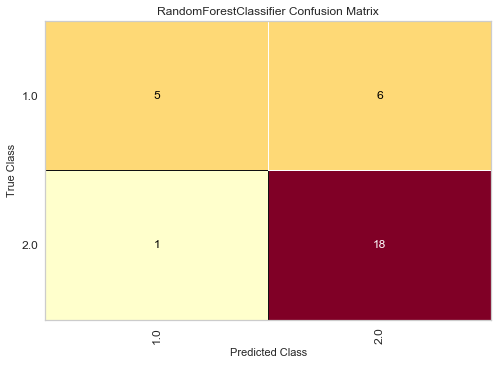

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ConfusionMatrix

from yellowbrick.classifier import ClassPredictionError
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(max_depth=5)

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model, classes=[1., 2.])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.poof()